# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [12]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, x,y,t):
        inputs = torch.cat([x,y,t], axis = 1)
        out = self.layers(inputs)
        return out

In [14]:
class ComplexHeatEquationNet(torch.nn.Module):
    def __init__(self):
        super(ComplexHeatEquationNet, self).__init__()
        self.fc1 = torch.nn.Linear(3, 512)
        self.ln1 = torch.nn.LayerNorm(512)
        self.silu1 = torch.nn.SiLU()
        self.fc2 = torch.nn.Linear(512, 256)
        self.ln2 = torch.nn.LayerNorm(256)
        self.silu2 = torch.nn.SiLU()
        self.fc3 = torch.nn.Linear(256, 128)
        self.ln3 = torch.nn.LayerNorm(128)
        self.silu3 = torch.nn.SiLU()
        self.fc4 = torch.nn.Linear(128, 64)
        self.ln4 = torch.nn.LayerNorm(64)
        self.silu4 = torch.nn.SiLU()
        self.fc5 = torch.nn.Linear(64, 32)
        self.ln5 = torch.nn.LayerNorm(32)
        self.silu5 = torch.nn.SiLU()
        self.fc6 = torch.nn.Linear(32, 1)

    def forward(self, x,y,t):
        X = torch.cat([x,y,t], axis = 1)
        x = self.silu1(self.ln1(self.fc1(X)))
        x = self.silu2(self.ln2(self.fc2(x)))
        x = self.silu3(self.ln3(self.fc3(x)))
        x = self.silu4(self.ln4(self.fc4(x)))
        x = self.silu5(self.ln5(self.fc5(x)))
        x = self.fc6(x)
        return x

In [15]:
def get_mgrid(sidelen, dim=2):
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    if dim == 2:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1]], axis=-1)[None,...].astype(np.float32)
        print(pixel_coords.shape)
        pixel_coords[0, :, :, 0] = pixel_coords[0, :, :, 0] / (sidelen[0] - 1)
        pixel_coords[0, :, :, 1] = pixel_coords[0, :, :, 1] / (sidelen[1] - 1)
    elif dim == 3:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1], :sidelen[2]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[..., 0] = pixel_coords[..., 0] / max(sidelen[0] - 1, 1)
        pixel_coords[..., 1] = pixel_coords[..., 1] / (sidelen[1] - 1)
        pixel_coords[..., 2] = pixel_coords[..., 2] / (sidelen[2] - 1)
    pixel_coords -= 0.5
    pixel_coords *= 2.
    pixel_coords = torch.Tensor(pixel_coords).view(-1, dim)
    return pixel_coords
    

In [16]:
class SineLayer(torch.nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(torch.nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        #coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        #inputs = torch.cat([x,y,t], axis = 1)
        output = self.net(coords)
        return output       

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [17]:
class DiffDataset(Dataset):
    def __init__ (self, sidelength,pretrain=False):
        super().__init__()
        torch.manual_seed(4321)
        self.sidelength = sidelength
        self.pretrain = pretrain
        self.mgrid = get_mgrid(self.sidelength).detach()
        self.Nsamples = 1000 
        self.counter = 0
        self.full_count = 10000
        # boundary values
        self.x_bc = torch.zeros(self.sidelength, 1).uniform_(0,2)
        self.y_bc = torch.zeros(self.sidelength, 1).uniform_(0,2)

    def __len__(self):
        return 1
        
    def analytic_sol_func(self, coords): 
        return torch.exp(coords[:,1] + coords[:,2]) * torch.cos(coords[:,1] + coords[:,2] + 4*coords[:,0])

    def __getitem__(self, index):
        start_time = 0.0
        # uniformly sample domain and include coordinates
        coords = torch.zeros(self.sidelength ** 2, 2).uniform_(0,2)

        # boundary values 
        boundary = torch.cat([torch.zeros_like(self.x_bc), self.x_bc, self.y_bc],1)
        boundary_values = self.analytic_sol_func(boundary)
        dirichlet1 = torch.cat([torch.ones_like(self.x_bc)*2,self.y_bc],1)
        dirichlet2 = torch.cat([torch.zeros_like(self.x_bc),self.y_bc],1)
        dirichlet3 = torch.cat([self.x_bc, torch.zeros_like(self.y_bc)],1)
        dirichlet4 = torch.cat([self.x_bc, torch.ones_like(self.y_bc)*2],1)
        dirichlet  = torch.cat([dirichlet1,dirichlet2,dirichlet3,dirichlet4])

        if self.pretrain:
            # only sample in time around the inital condition
            time = torch.zeros(self.sidelength ** 2, 1).uniform_(start_time - 0.001, start_time + 0.001)
            time_boundary = torch.zeros(dirichlet.shape[0], 1).uniform_(start_time - 0.001, start_time + 0.001)
            coords = torch.cat((time, coords), dim=1)
            dirichlet = torch.cat((time_boundary, dirichlet),dim=1)
        else:
            # slowly grow time values from start time
            time = torch.zeros(self.sidelength ** 2, 1).uniform_(0,0.4*(self.counter / self.full_count))
            time_boundary = torch.zeros(dirichlet.shape[0], 1).uniform_(0,0.4*(self.counter / self.full_count))
            coords = torch.cat((time,coords), dim=1)
            dirichlet = torch.cat((time_boundary, dirichlet),dim=1)
        self.counter += 1

        if self.pretrain and self.counter == 2000:
            self.pretrain = False
            self.counter = 0
        return {"coords":  coords},{"boundary":boundary, "boundary_values": boundary_values, "dirichlet": dirichlet}        



In [7]:
import matplotlib.pyplot as plt
dataset = DiffDataset(6, pretrain=True)
dataloader = DataLoader(dataset, shuffle=True, batch_size=16, pin_memory=True, num_workers=0)
for step, (model_input, gt) in enumerate(dataloader):
    model_input = {key: value for key, value in model_input.items()}
    gt = {key: value for key, value in gt.items()}
    
    print(f"step: {step}")
    print(model_input["coords"].shape)
    print(gt["dirichlet"])

(1, 6, 6, 2)
step: 0
torch.Size([1, 36, 3])
tensor([[[ 5.9175e-05,  2.0000e+00,  6.1351e-01],
         [-2.9765e-04,  2.0000e+00,  1.9000e+00],
         [ 8.7274e-04,  2.0000e+00,  8.6429e-01],
         [ 5.3889e-04,  2.0000e+00,  5.8921e-01],
         [ 8.5615e-04,  2.0000e+00,  1.2031e+00],
         [-7.2305e-04,  2.0000e+00,  3.5231e-01],
         [-9.5677e-04,  0.0000e+00,  6.1351e-01],
         [ 5.7158e-05,  0.0000e+00,  1.9000e+00],
         [ 9.9725e-04,  0.0000e+00,  8.6429e-01],
         [ 8.6209e-04,  0.0000e+00,  5.8921e-01],
         [-5.5559e-04,  0.0000e+00,  1.2031e+00],
         [ 4.0102e-04,  0.0000e+00,  3.5231e-01],
         [ 8.8370e-04,  2.5108e-01,  0.0000e+00],
         [-2.4388e-04,  1.0753e+00,  0.0000e+00],
         [ 5.4799e-04,  1.3128e+00,  0.0000e+00],
         [-3.1152e-04,  7.3020e-02,  0.0000e+00],
         [ 7.6711e-05,  1.1673e+00,  0.0000e+00],
         [ 4.9407e-05,  1.4036e+00,  0.0000e+00],
         [ 2.1604e-06,  2.5108e-01,  2.0000e+00],
      

RuntimeError: shape '[36, 36]' is invalid for input of size 36

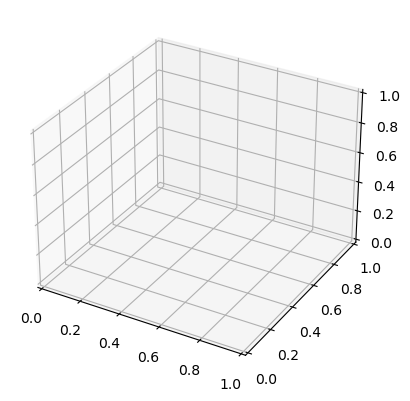

In [70]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')
xm = data[0,2][:,1]
ym = data[0,2][:,2]
X,Y = torch.meshgrid(xm,ym)
um = data.analytic_sol_func(data[0,2])
um = um.reshape(X.shape)

surf = ax.plot_surface(xm, ym, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [20]:
learn_rate = 0.01
class Net:
    def __init__(self, model = "diff"):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        # build model
        if model == "diff":
            self.model = DiffNet(
               input_size=3,
               hidden_size=50,
               output_size=1,
               depth=5,
               act=torch.nn.Tanh).to(device)
        elif model == "siren":
            self.model = Siren(in_features=3, 
                               out_features=1, 
                               hidden_features=50, 
                               hidden_layers=10, 
                               outermost_linear=True).to(device)
        elif model == "complex":
            self.model = ComplexHeatEquationNet().to(device)
        self.model_input = {}
        self.gt = {}
        # Initial and boundary conditions
        x = np.random.uniform(low=0.,high=2., size=(141,1))
        y = np.random.uniform(low=0.,high=2., size=(141,1))
        t = np.random.uniform(low=0.,high=2., size=(141,1))
        
        
        self.x_bc = torch.from_numpy(x).float().to(device)
        self.x_bc.requires_grad = False
        self.y_bc = torch.from_numpy(y).float().to(device)
        self.y_bc.requires_grad = False
        self.t_bc = torch.from_numpy(t).float().to(device)
        self.t_bc.requires_grad = False
        
        self.x = torch.from_numpy(x).float().to(device)
        self.x.requires_grad = True
        self.y = torch.from_numpy(y).float().to(device)
        self.y.requires_grad = True
        self.t = torch.from_numpy(t).float().to(device)
        self.t.requires_grad = True
        self.all_zeros = torch.zeros_like(self.x).to(device)
        self.all_zeros.requires_grad = False
        
        #initial and boundary condition 
        self.u_init = self.analytic_sol_func(torch.tensor(0.0), self.x_bc, self.y_bc)
        self.u_xmin = self.analytic_sol_func(self.t_bc, torch.zeros_like(self.x_bc), self.y_bc)
        self.u_xmax = self.analytic_sol_func(self.t_bc, torch.ones_like(self.x_bc)*2.0, self.y_bc)
        self.u_ymin = self.analytic_sol_func(self.t_bc, self.x_bc, torch.zeros_like(self.y_bc))
        self.u_ymax = self.analytic_sol_func(self.t_bc, self.x_bc, torch.ones_like(self.y_bc)*2.0)
        
        
        self.mse_cost_function = nn.MSELoss()
       # self.optimizer = torch.optim.LBFGS(self.model.parameters(),lr=learn_rate,max_iter=500,max_eval=50000,
       #                           history_size=50,tolerance_grad=1e-5,tolerance_change=1.0 * np.finfo(float).eps)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.iter = 0
        
    def analytic_sol_func(self, t, x, y): 
        return torch.exp(x + y) * torch.cos(x + y + 4*t)
    
    def f(self, coords):
        u = self.model(coords).requires_grad_(True) 
        t = coords[...,0].requires_grad_(True)  
        x = coords[...,1].requires_grad_(True)   
        y = coords[...,2].requires_grad_(True)

        print(u)
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True, 
        )[0]
        
        print(torch.is_tensor(u),) 
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]
        print(torch.is_tensor(u_x))
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]
        
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]
        
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]
        return u_t - u_xx - u_yy
    
    def loss_func(self):
    
        model_input = self.model_input
        gt = self.gt
        # initial boundary condition
        #out = self.model(self.x_bc, self.y_bc, self.t_bc)
        #mse_u = self.mse_cost_function(out, self.u_init)
              
    
        # boundary conditions
        out = self.model(gt["boundary"])
        mse_boundary = self.mse_cost_function(out, gt["boundary_values"])
        out = self.f(model_input["coords"])
        mse_f = self.mse_cost_function(out, self.all_zeros)

        #out = self.model(torch.zeros_like(self.x_bc), self.y_bc, self.t_bc)
        #mse_u_xmin = self.mse_cost_function(out, self.u_xmin)
        
        #out = self.model(torch.ones_like(self.x_bc)*2.0, self.y_bc, self.t_bc)
        #mse_u_xmax = self.mse_cost_function(out, self.u_xmax)
        
        #out = self.model(self.x_bc, torch.zeros_like(self.y_bc), self.t_bc)
        #mse_u_ymin = self.mse_cost_function(out, self.u_ymin)
        
        #out = self.model(self.x_bc, torch.ones_like(self.y_bc)*2.0, self.t_bc)
        #mse_u_ymax = self.mse_cost_function(out, self.u_ymax)
        
        ## fix condition for PDE
        #out = self.f(self.x, self.y, self.t)
        #mse_f = self.mse_cost_function(out, self.all_zeros)
    
        #loss = mse_u + mse_u_xmax + mse_u_xmin + mse_u_ymax + mse_u_ymin + mse_f
        loss = mse_boundary + mse_f
        self.optimizer.zero_grad()
        loss.backward()
        
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
        
    def train(self,epochs,dataloader):
        for epoch in range(epochs):

            for step, (model_input, gt) in enumerate(dataloader):
                model_input = {key: value.cuda() for key, value in model_input.items()}
                gt = {key: value.cuda() for key, value in gt.items()}
                self.model_input = model_input
                self.gt = gt
                self.optimizer.step(self.loss_func)

In [21]:
dataset = DiffDataset(6)
dataloader = DataLoader(dataset, shuffle=True, batch_size=16, pin_memory=True, num_workers=0)
net = Net(model="siren")
net.train(1000, dataloader)

(1, 6, 6, 2)
tensor([[[ 0.0080],
         [-0.0115],
         [ 0.0177],
         [ 0.0128],
         [-0.0029],
         [-0.0134],
         [-0.0041],
         [ 0.0008],
         [ 0.0078],
         [ 0.0147],
         [-0.0085],
         [-0.0207],
         [ 0.0071],
         [ 0.0092],
         [-0.0045],
         [ 0.0126],
         [ 0.0096],
         [ 0.0135],
         [-0.0088],
         [ 0.0064],
         [ 0.0048],
         [-0.0002],
         [ 0.0092],
         [-0.0034],
         [ 0.0104],
         [ 0.0130],
         [ 0.0016],
         [-0.0070],
         [ 0.0306],
         [ 0.0082],
         [ 0.0087],
         [ 0.0191],
         [ 0.0180],
         [ 0.0163],
         [-0.0050],
         [ 0.0177]]], device='cuda:0', grad_fn=<ViewBackward0>)


c:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 6])) that is different to the input size (torch.Size([1, 6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [14]:
net.analytic_sol_func(torch.tensor([0,1,2]), torch.tensor([1.1,1.2,1.3]), torch.tensor([2.2,2.3,2.3]))

tensor([-26.7732,  11.4790,  20.7984])

In [15]:
net.train(10000)

 Iter: 10000, loss:136.1151885986328
 Iter: 10100, loss:140.32379150390625
 Iter: 10200, loss:147.3084716796875
 Iter: 10300, loss:133.34681701660156
 Iter: 10400, loss:427.020263671875
 Iter: 10500, loss:332.375732421875
 Iter: 10600, loss:780.1793823242188
 Iter: 10700, loss:757.8553466796875
 Iter: 10800, loss:734.3298950195312
 Iter: 10900, loss:717.2371826171875
 Iter: 11000, loss:703.6803588867188
 Iter: 11100, loss:693.8895874023438
 Iter: 11200, loss:687.1901245117188
 Iter: 11300, loss:681.1494140625
 Iter: 11400, loss:674.2111206054688
 Iter: 11500, loss:664.6980590820312
 Iter: 11600, loss:647.4249877929688
 Iter: 11700, loss:605.1610717773438
 Iter: 11800, loss:486.4866638183594
 Iter: 11900, loss:467.438232421875
 Iter: 12000, loss:577.19873046875
 Iter: 12100, loss:315.28857421875
 Iter: 12200, loss:485.9299621582031
 Iter: 12300, loss:304.2768859863281
 Iter: 12400, loss:194.95765686035156
 Iter: 12500, loss:212.8760986328125
 Iter: 12600, loss:262.91998291015625
 Iter: 

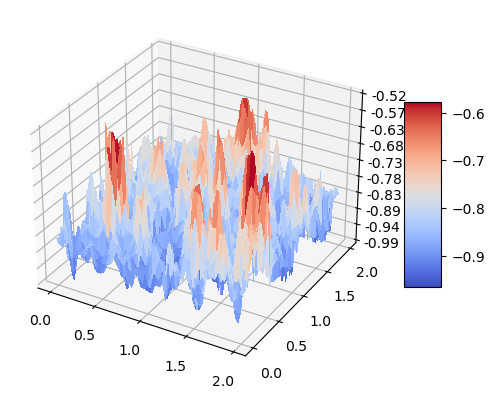

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')

x = np.arange(0,2,0.02)
y = np.arange(0,2,.02)
xm, ym = np.meshgrid(x,y)

x = np.ravel(xm).reshape(-1,1)
y = np.ravel(ym).reshape(-1,1)

x_input = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
y_input = Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)

u_pred = net.model(x_input, y_input, torch.ones_like(x_input)*2.0)
um = u_pred.data.cpu().numpy()
um = um.reshape(xm.shape)

surf = ax.plot_surface(xm, ym, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [12]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,2)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)

In [13]:
mse

39.87120150159366